## Import libraries

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
import math
import smtplib
import pickle
import itertools

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Lambda, concatenate
from keras import backend as K
#from keras.utils import multi_gpu_model
from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7']


## Patched multi_gpu_model function

This is needed to work around saving errors with parallel models. See https://stackoverflow.com/questions/47210811/can-not-save-model-using-model-save-following-multi-gpu-model-in-keras/48066771#48066771. Note that loading the model is slightly different, as described in the link.

In [2]:
def multi_gpu_model(model, gpus):
    if isinstance(gpus, (list, tuple)):
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                           output_shape=input_shape,
                           arguments={'i': i,
                                      'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(concatenate(outputs,
                                axis=0, name=name))
        return Model(model.inputs, merged)

## Train a VGGnet on image data

Use VGG19 pretrained on ImageNet to train on retinal OCT dataset using transfer learning, data augmentation

In [36]:
# Constants
img_width, img_height = 256, 256
train_data_dir = "data/train"
validation_data_dir = "data/val"
test_data_dir = "data/test"
nb_train_samples = 66813
nb_validation_samples = 16703
batch_size = 128
epochs = 50
learning_rate = 0.001
mu = 0.9 # Momentum

In [17]:
# Load pretrained model
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

We may need to modify the layers based on our dataset - it is small and different from ImageNet. See https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

In [18]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# Parallel computing
model_final = multi_gpu_model(model_final, gpus=8)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=learning_rate, momentum=mu), metrics=["accuracy"])


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [19]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  horizontal_flip = True,
                                  fill_mode = "nearest",
                                  zoom_range = 0.3,
                                  width_shift_range = 0.3,
                                  height_shift_range=0.3,
                                  rotation_range=30)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size = (img_height, img_width),
                                                        class_mode = "categorical")

Found 66813 images belonging to 4 classes.
Found 16703 images belonging to 4 classes.


In [20]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg19_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [21]:
# Train the model 
vgg_history = model_final.fit_generator(train_generator,
                                        steps_per_epoch = math.floor(nb_train_samples/batch_size),
                                        epochs = epochs,
                                        validation_data = validation_generator,
                                        validation_steps = math.floor(nb_validation_samples/batch_size),
                                        callbacks = [checkpoint, early])
# Save history
with open('vgg_train_history.p', 'wb') as f:
    pickle.dump(vgg_history.history,f)
    
# Email notification for when this is done
server = smtplib.SMTP('smtp.gmail.com', 587)
server.starttls()
server.login("raa421@gmail.com", "Reventon21!")
 
msg = "HELLO SIR YOUR NETWORK IS TRAINED"
server.sendmail("raa421@gmail.com", "rafiayub@stanford.edu", msg)
server.quit()
print('Done.')

Epoch 1/50
521/521 [==============================] - 1389s 3s/step - loss: 0.4238 - acc: 0.8523 - val_loss: 0.4072 - val_acc: 0.8584

Epoch 00001: val_acc improved from -inf to 0.85841, saving model to vgg16_1.h5
Epoch 2/50
521/521 [==============================] - 1386s 3s/step - loss: 0.2097 - acc: 0.9295 - val_loss: 0.6079 - val_acc: 0.8195

Epoch 00002: val_acc did not improve
Epoch 3/50
521/521 [==============================] - 1365s 3s/step - loss: 0.1776 - acc: 0.9404 - val_loss: 0.3422 - val_acc: 0.8880

Epoch 00003: val_acc improved from 0.85841 to 0.88798, saving model to vgg16_1.h5
Epoch 4/50
521/521 [==============================] - 1394s 3s/step - loss: 0.1595 - acc: 0.9471 - val_loss: 0.2628 - val_acc: 0.9224

Epoch 00004: val_acc improved from 0.88798 to 0.92236, saving model to vgg16_1.h5
Epoch 5/50
521/521 [==============================] - 1388s 3s/step - loss: 0.1517 - acc: 0.9492 - val_loss: 0.2740 - val_acc: 0.9142

Epoch 00005: val_acc did not improve
Epoch 6/

In [27]:
# Load history
with open('vgg_train_history.p', 'rb') as f:
    train_history = pickle.load(f)

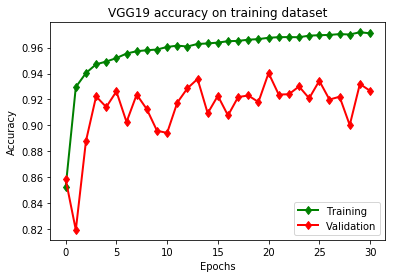

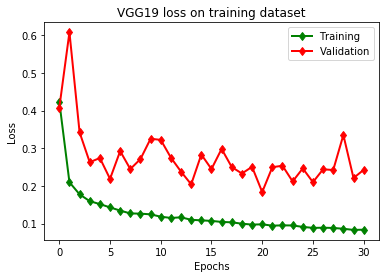

In [34]:
# History is a dictionary with keys ['acc','loss','val_acc','val_loss'] per epoch
plt.plot(train_history['acc'], label='Training', color='g',linewidth=2,marker='d')
plt.plot(train_history['val_acc'], label='Validation', color='r',linewidth=2,marker='d')
plt.legend()
plt.title('VGG19 accuracy on training dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('vgg19_acc.jpg')
plt.show()

plt.plot(train_history['loss'], label='Training',color='g',linewidth=2,marker='d')
plt.plot(train_history['val_loss'], label='Validation',color='r',linewidth=2,marker='d')
plt.title('VGG19 loss on training dataset')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('vgg19_loss.jpg')
plt.show()

In [38]:
# Test the network!! First initiate test generator
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                        target_size = (img_height, img_width),
                                                        class_mode = "categorical")
# Now test model
test_loss = model_final.evaluate_generator(test_generator)

Found 968 images belonging to 4 classes.


In [41]:
model_final.metrics_names

['loss', 'acc']

In [42]:
print('Test loss: ', test_loss[0])
print('Test acc: ', test_loss[1])
with open('vgg_test_loss.p', 'wb') as f:
    pickle.dump(test_loss,f)

Test loss:  0.05007989506302993
Test acc:  0.9865702479338843


## Train an InceptionV3 net

Configuration is based on previous work in Kermany et al.

In [17]:
# Constants
img_width, img_height = 256, 256
train_data_dir = "data/train"
validation_data_dir = "data/val"
test_data_dir = "data/test"
nb_train_samples = 66813
nb_validation_samples = 16703
batch_size = 1000
epochs = 50
learning_rate = 0.001
#mu = 0.9 # Momentum

In [18]:
# Load pretrained model
model = applications.InceptionV3(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 127, 127, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 127, 127, 32) 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 127, 127, 32) 0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_284

In [19]:
#Adding custom Layers 
x = model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

model_final.summary()

# Freeze all layers except final Dense softmax layer
for layer in model_final.layers[:-1]:
    layer.trainable = False
    
# Parallel computing
model_final = multi_gpu_model(model_final, gpus=2)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(), metrics=["accuracy"])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 127, 127, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 127, 127, 32) 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 127, 127, 32) 0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_284

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [20]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  horizontal_flip = True,
                                  fill_mode = "nearest",
                                  zoom_range = 0.3,
                                  width_shift_range = 0.3,
                                  height_shift_range=0.3,
                                  rotation_range=30)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size = (img_height, img_width),
                                                        class_mode = "categorical")

Found 66813 images belonging to 4 classes.
Found 16703 images belonging to 4 classes.


In [ ]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("InceptionV3.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [ ]:
# Train the model 
incepv3_history = model_final.fit_generator(train_generator,
                                        steps_per_epoch = math.floor(nb_train_samples/batch_size),
                                        epochs = epochs,
                                        validation_data = validation_generator,
                                        validation_steps = math.floor(nb_validation_samples/batch_size),
                                        callbacks = [checkpoint, early])
# Save history
with open('incepv3_train_history.p', 'wb') as f:
    pickle.dump(incepv3_history.history,f)
    
# Email notification for when this is done
server = smtplib.SMTP('smtp.gmail.com', 587)
server.starttls()
server.login("raa421@gmail.com", "Reventon21!")
 
msg = "HELLO SIR YOUR NETWORK IS TRAINED"
server.sendmail("raa421@gmail.com", "rafiayub@stanford.edu", msg)
server.quit()
print('Done.')

Epoch 1/50
20/66 [========>.....................] - ETA: 37:59 - loss: 1.1187 - acc: 0.5431

In [24]:
# Load history
with open('incepv3_train_history.p', 'rb') as f:
    train_history = pickle.load(f)

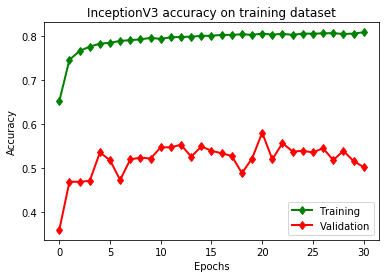

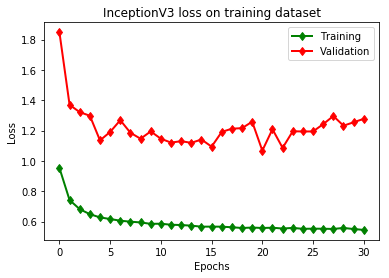

In [25]:
# History is a dictionary with keys ['acc','loss','val_acc','val_loss'] per epoch
plt.plot(train_history['acc'], label='Training', color='g',linewidth=2,marker='d')
plt.plot(train_history['val_acc'], label='Validation', color='r',linewidth=2,marker='d')
plt.legend()
plt.title('InceptionV3 accuracy on training dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('incepv3_acc.jpg')
plt.show()

plt.plot(train_history['loss'], label='Training',color='g',linewidth=2,marker='d')
plt.plot(train_history['val_loss'], label='Validation',color='r',linewidth=2,marker='d')
plt.title('InceptionV3 loss on training dataset')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('incepv3_loss.jpg')
plt.show()

In [26]:
# Test the network!! First initiate test generator
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                        target_size = (img_height, img_width),
                                                        class_mode = "categorical")
# Now test model
test_loss = model_final.evaluate_generator(test_generator)

Found 968 images belonging to 4 classes.


In [27]:
model_final.metrics_names

['loss', 'acc']

In [28]:
print('Test loss: ', test_loss[0])
print('Test acc: ', test_loss[1])
with open('incepv3_test_loss.p', 'wb') as f:
    pickle.dump(test_loss,f)

Test loss:  0.9668160736068221
Test acc:  0.6384297520661157


## Compare performance of both nets

#### Load all variables

In [2]:
with open('incepv3_test_loss.p', 'rb') as f:
    iv3testloss = pickle.load(f)
with open('vgg_test_loss.p', 'rb') as f:
    vggtestloss = pickle.load(f)
with open('incepv3_train_history.p', 'rb') as f:
    iv3hist = pickle.load(f)
with open('vgg_train_history.p', 'rb') as f:
    vgghist = pickle.load(f) 
    
print('Done.')

Done.


#### Plot accuracy and loss

Text(0.5,0.98,'Performance comparison of VGG19 and InceptionV3')

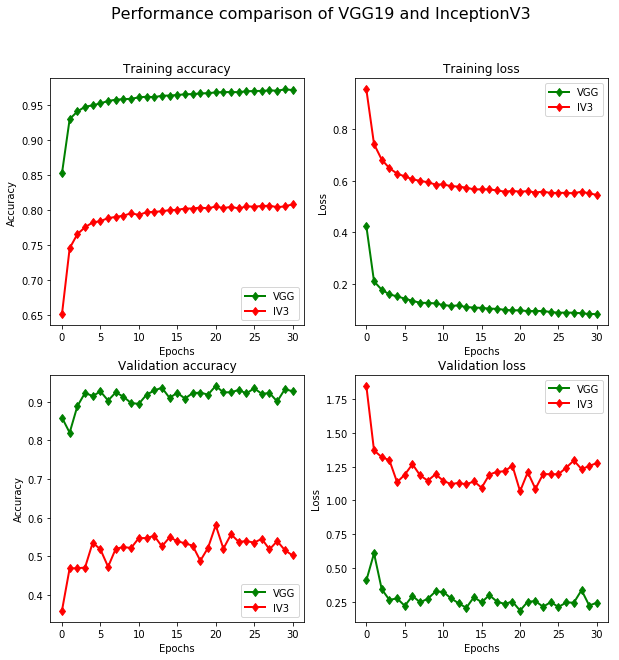

In [83]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.figure()
f, ax = plt.subplots(2,2)
# Training accuracy
ax[0,0].plot(vgghist['acc'], label='VGG', color='g',linewidth=2,marker='d')
ax[0,0].plot(iv3hist['acc'], label='IV3', color='r',linewidth=2,marker='d')
ax[0,0].set_title('Training accuracy')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Accuracy')
ax[0,0].legend()
# Training loss
ax[0,1].plot(vgghist['loss'], label='VGG', color='g',linewidth=2,marker='d')
ax[0,1].plot(iv3hist['loss'], label='IV3', color='r',linewidth=2,marker='d')
ax[0,1].set_title('Training loss')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend()
# Validation accuracy
ax[1,0].plot(vgghist['val_acc'], label='VGG', color='g',linewidth=2,marker='d')
ax[1,0].plot(iv3hist['val_acc'], label='IV3', color='r',linewidth=2,marker='d')
ax[1,0].set_title('Validation accuracy')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].legend()
# Validation loss
ax[1,1].plot(vgghist['val_loss'], label='VGG', color='g',linewidth=2,marker='d')
ax[1,1].plot(iv3hist['val_loss'], label='IV3', color='r',linewidth=2,marker='d')
ax[1,1].set_title('Validation loss')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend()
plt.suptitle('Performance comparison of VGG19 and InceptionV3', fontsize=16)

#### Compare accuracies with model in paper

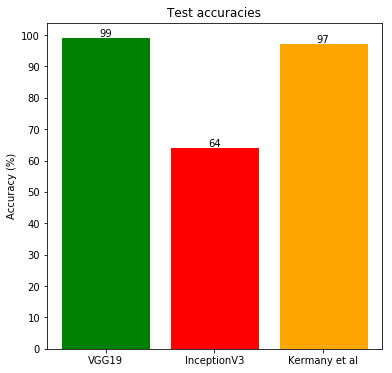

In [4]:
plt.rcParams['figure.figsize'] = (6, 6)

b = plt.bar([0,1,2],[round(100*vggtestloss[1]),round(100*iv3testloss[1]),97])

b[0].set_color('g')
b[1].set_color('r')
b[2].set_color('orange')
for rect in b:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.xticks([0,1,2],('VGG19','InceptionV3','Kermany et al'))
plt.yticks(np.linspace(0,100,11))
plt.ylabel('Accuracy (%)')
plt.title('Test accuracies')
plt.show()

## Visualization

#### Load models and libraries needed - we use the help of a new module called keras-vis.

In [12]:
from vis.utils import utils
from keras import activations
import matplotlib.cm as cm
from vis.visualization import visualize_cam, visualize_saliency, overlay

vgg_model = load_model('vgg16_1.h5', custom_objects={'tf':tf})
incepv3_model = load_model('InceptionV3.h5',custom_objects={'tf':tf})

# Extract the model from the parallel computing model
vgg_model = vgg_model.layers[-2]
incepv3_model = incepv3_model.layers[-2]

print('Models loaded.')

Models loaded.


#### Change the top layer of both models from softmax to linear for visualization.

In [14]:
vgg_model.layers[-1].activation = activations.linear
vgg_model = utils.apply_modifications(vgg_model)

incepv3_model.layers[-1].activation = activations.linear
incepv3_model = utils.apply_modifications(incepv3_model)

print('Done.')

/home/shared/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Done.


#### Load images to view saliency maps for - two from each category

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


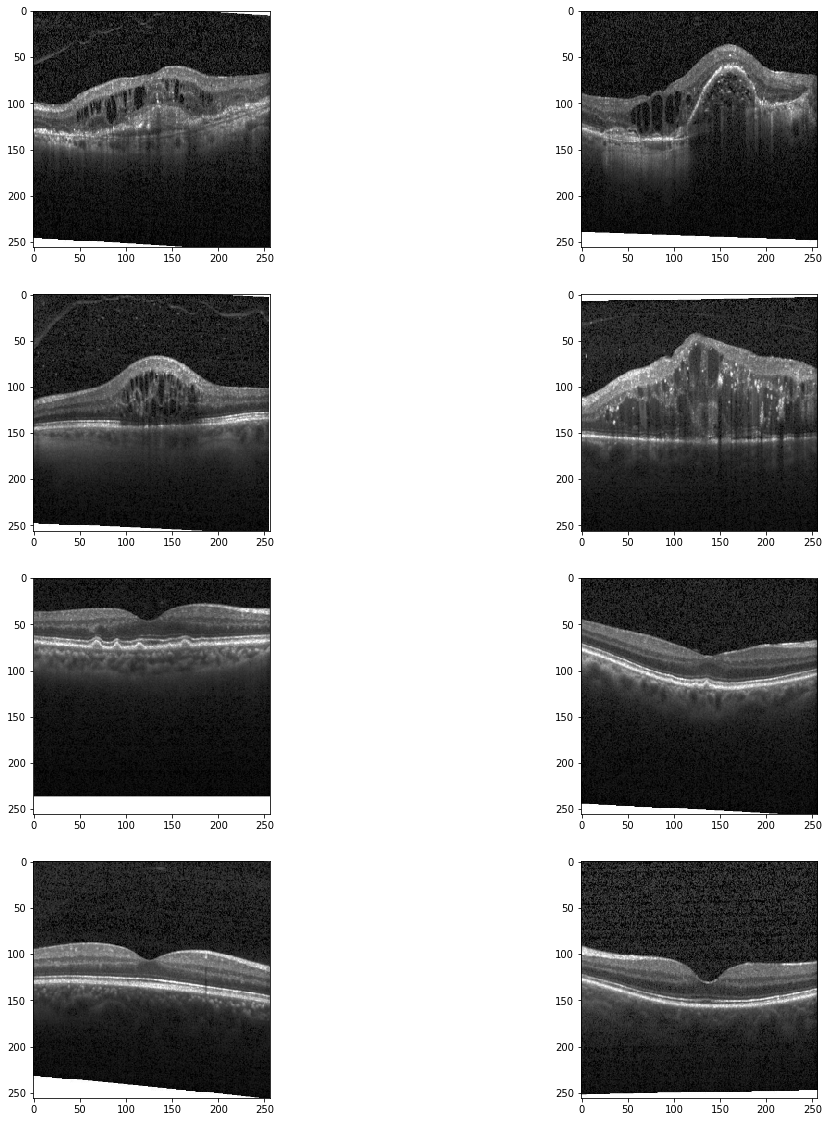

In [75]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 20)

img1 = utils.load_img('data/test/CNV/CNV-6190971-1.jpeg', target_size=(256, 256, 3))
img2 = utils.load_img('data/test/CNV/CNV-5813701-3.jpeg', target_size=(256, 256, 3))
img3 = utils.load_img('data/test/DME/DME-7837305-5.jpeg', target_size=(256, 256, 3))
img4 = utils.load_img('data/test/DME/DME-9378346-1.jpeg', target_size=(256, 256, 3))
img5 = utils.load_img('data/test/DRUSEN/DRUSEN-8117834-1.jpeg', target_size=(256, 256, 3))
img6 = utils.load_img('data/test/DRUSEN/DRUSEN-8345703-2.jpeg', target_size=(256, 256, 3))
img7 = utils.load_img('data/test/NORMAL/NORMAL-1908313-1.jpeg', target_size=(256, 256, 3))
img8 = utils.load_img('data/test/NORMAL/NORMAL-2055634-1.jpeg', target_size=(256, 256, 3))

f, ax = plt.subplots(4, 2)
ax[0,0].imshow(img1[:,:,1], cmap='gray')
ax[0,1].imshow(img2[:,:,1], cmap='gray')
ax[1,0].imshow(img3[:,:,1], cmap='gray')
ax[1,1].imshow(img4[:,:,1], cmap='gray')
ax[2,0].imshow(img5[:,:,1], cmap='gray')
ax[2,1].imshow(img6[:,:,1], cmap='gray')
ax[3,0].imshow(img7[:,:,1], cmap='gray')
ax[3,1].imshow(img8[:,:,1], cmap='gray')

#### Visualize saliency for VGG19

Processing image 1...
Processing image 2...
Processing image 3...
Processing image 4...
Processing image 5...
Processing image 6...
Processing image 7...
Processing image 8...


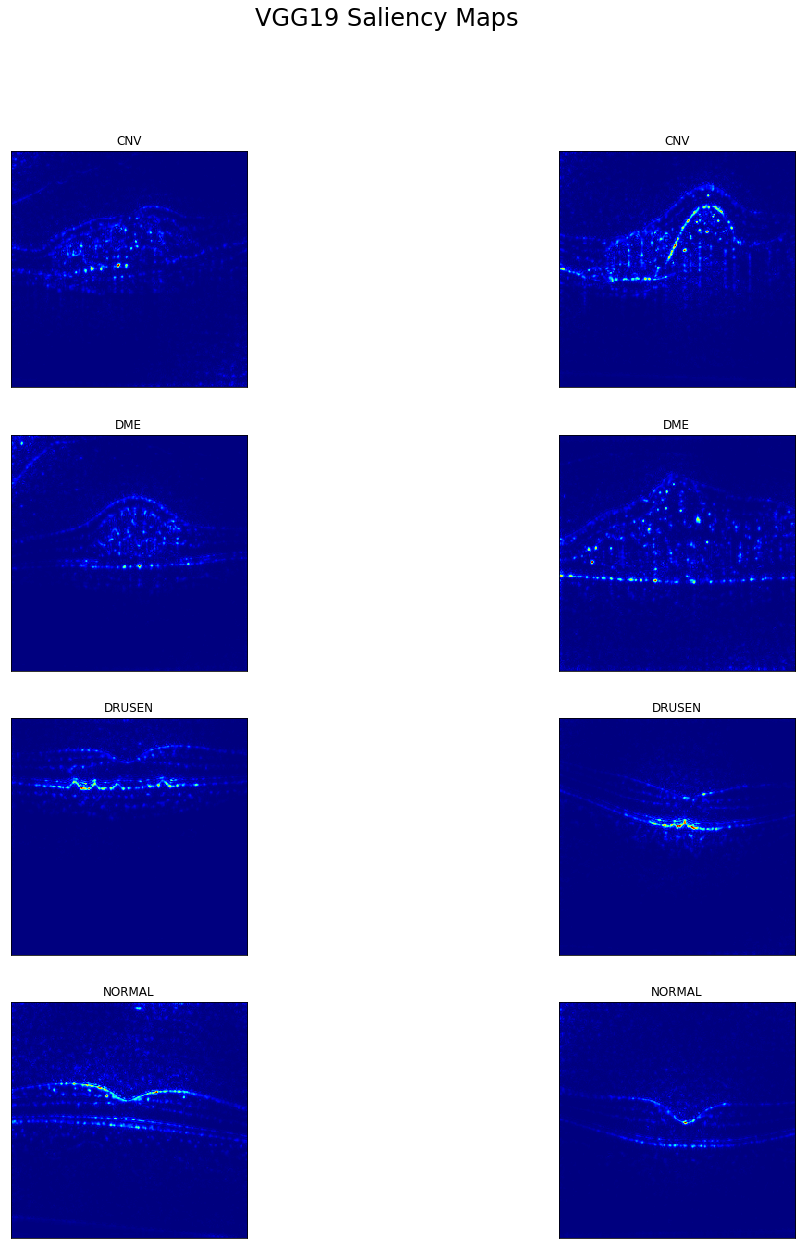

In [33]:
plt.figure()
f, ax = plt.subplots(4, 2)
plt.suptitle('VGG19 Saliency Maps', fontsize = 24)
for i, img in enumerate([img1, img2, img3, img4, img5, img6, img7, img8]):  
    print('Processing image %d...' % (i+1))
    grads = visualize_saliency(vgg_model, -1, filter_indices = None, seed_input=img, backprop_modifier='guided')
    row = math.floor(i/2)
    col = i % 2
    if row == 0: title = 'CNV'
    elif row == 1: title = 'DME'
    elif row == 2: title = 'DRUSEN'
    elif row == 3: title = 'NORMAL'
    # visualize grads as heatmap
    ax[row,col].imshow(grads, cmap='jet')
    ax[row,col].set_title(title)
    ax[row,col].get_xaxis().set_visible(False)
    ax[row,col].get_yaxis().set_visible(False)

#### Visualize saliency for InceptionV3

Processing image 1...
Processing image 2...
Processing image 3...
Processing image 4...
Processing image 5...
Processing image 6...
Processing image 7...
Processing image 8...


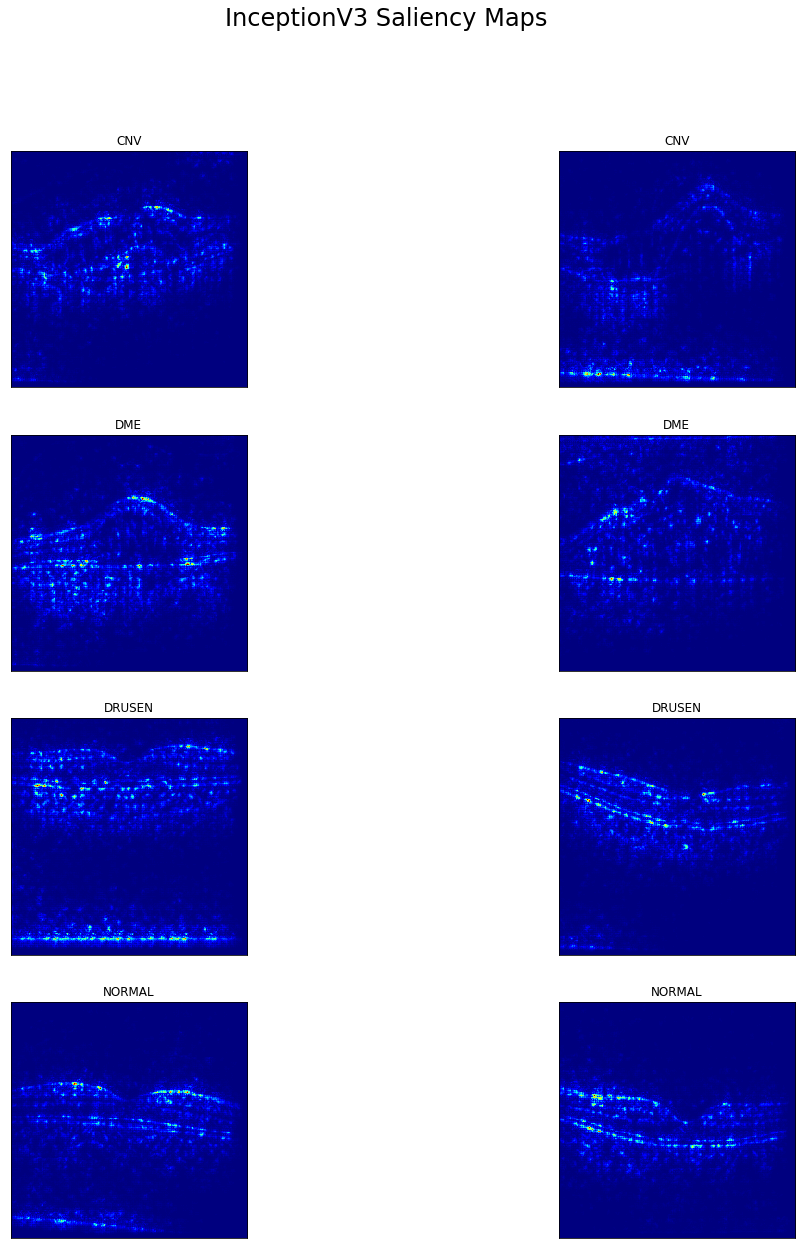

In [34]:
plt.figure()
f, ax = plt.subplots(4, 2)
plt.suptitle('InceptionV3 Saliency Maps', fontsize = 24)
for i, img in enumerate([img1, img2, img3, img4, img5, img6, img7, img8]):  
    print('Processing image %d...' % (i+1))
    grads = visualize_saliency(incepv3_model, -1, filter_indices = None, seed_input=img, backprop_modifier='guided')
    row = math.floor(i/2)
    col = i % 2
    if row == 0: title = 'CNV'
    elif row == 1: title = 'DME'
    elif row == 2: title = 'DRUSEN'
    elif row == 3: title = 'NORMAL'
    # visualize grads as heatmap
    ax[row,col].imshow(grads, cmap='jet')
    ax[row,col].set_title(title)
    ax[row,col].get_xaxis().set_visible(False)
    ax[row,col].get_yaxis().set_visible(False)

#### Visualize class activation maps (CAM) for VGG19 and InceptionV3

Processing image 1...
Processing image 2...
Processing image 3...
Processing image 4...
Processing image 5...
Processing image 6...
Processing image 7...
Processing image 8...


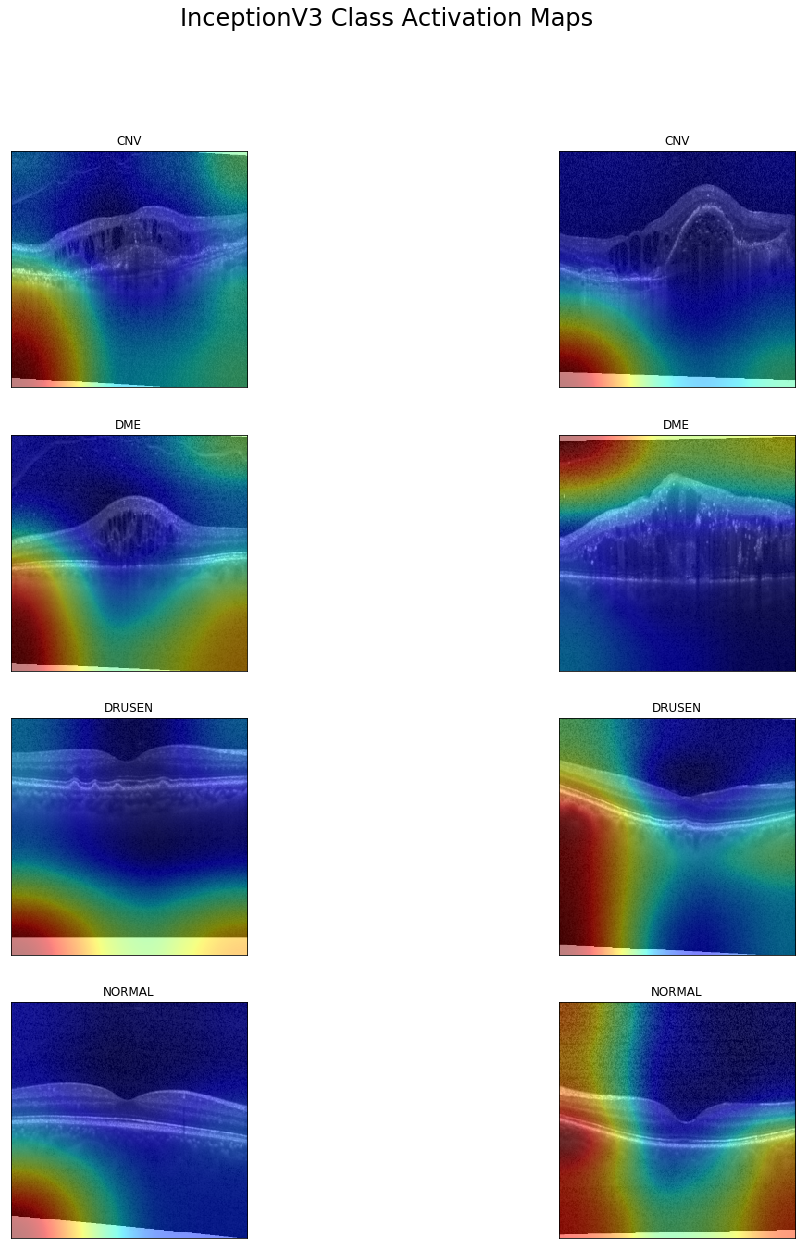

In [76]:
plt.figure()
f, ax = plt.subplots(4, 2)
plt.suptitle('InceptionV3 Class Activation Maps', fontsize = 24)
for i, img in enumerate([img1, img2, img3, img4, img5, img6, img7, img8]):  
    print('Processing image %d...' % (i+1))
    grads = visualize_cam(incepv3_model, -1, filter_indices=None, 
                          seed_input=img, backprop_modifier='guided') 
    row = math.floor(i/2)
    col = i % 2
    if row == 0: title = 'CNV'
    elif row == 1: title = 'DME'
    elif row == 2: title = 'DRUSEN'
    elif row == 3: title = 'NORMAL'
    
    img = np.concatenate((img[:,:,1][:,:,np.newaxis],img[:,:,1][:,:,np.newaxis],img[:,:,1][:,:,np.newaxis]),axis=2)
    
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = grads
    ax[row,col].imshow(overlay(jet_heatmap, img))
    ax[row,col].set_title(title)
    ax[row,col].get_xaxis().set_visible(False)
    ax[row,col].get_yaxis().set_visible(False)

Processing image 1...
Processing image 2...
Processing image 3...
Processing image 4...
Processing image 5...
Processing image 6...
Processing image 7...
Processing image 8...


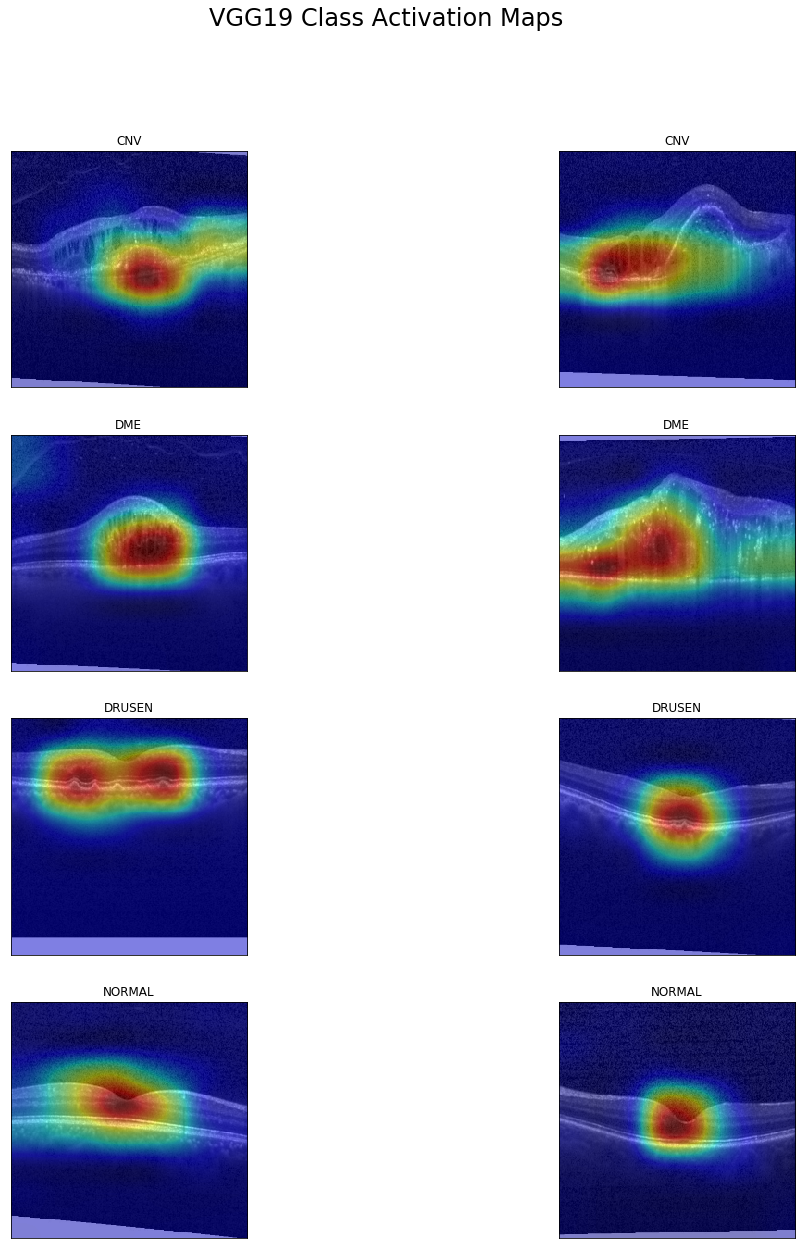

In [71]:
plt.figure()
f, ax = plt.subplots(4, 2)
plt.suptitle('VGG19 Class Activation Maps', fontsize = 24)
for i, img in enumerate([img1, img2, img3, img4, img5, img6, img7, img8]):  
    print('Processing image %d...' % (i+1))
    grads = visualize_cam(vgg_model, -1, filter_indices=None, 
                          seed_input=img, backprop_modifier='guided') 
    row = math.floor(i/2)
    col = i % 2
    if row == 0: title = 'CNV'
    elif row == 1: title = 'DME'
    elif row == 2: title = 'DRUSEN'
    elif row == 3: title = 'NORMAL'
    
    img = np.concatenate((img[:,:,1][:,:,np.newaxis],img[:,:,1][:,:,np.newaxis],img[:,:,1][:,:,np.newaxis]),axis=2)
    
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = grads
    ax[row,col].imshow(overlay(jet_heatmap, img))
    ax[row,col].set_title(title)
    ax[row,col].get_xaxis().set_visible(False)
    ax[row,col].get_yaxis().set_visible(False)

## ROC curves and Confusion Matrices

#### Load VGG

In [4]:
# Load the VGG model
vgg = load_model('vgg16_1.h5', custom_objects={'tf':tf})
print('Done.')

Done.


#### Test VGG

In [6]:
# Constants
img_width, img_height = 256, 256
train_data_dir = "data/train"
validation_data_dir = "data/val"
test_data_dir = "data/test"

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  horizontal_flip = True,
                                  fill_mode = "nearest",
                                  zoom_range = 0.3,
                                  width_shift_range = 0.3,
                                  height_shift_range=0.3,
                                  rotation_range=30)
# Test the network!! First initiate test generator
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                        target_size = (img_height, img_width),
                                                        class_mode = "categorical",
                                                        shuffle = False)
# Now test model
y_pred = vgg.predict_generator(test_generator)
print('Done.')

Found 968 images belonging to 4 classes.
Done.


In [11]:
y_pred_real = np.argmax(y_pred,axis=1)
y_test = test_generator.classes

#### Confusion matrix

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[239   3   0   0]
 [  0 242   0   0]
 [  4   0 237   1]
 [  0   0   0 242]]
Normalized confusion matrix
[[0.99 0.01 0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.02 0.   0.98 0.  ]
 [0.   0.   0.   1.  ]]


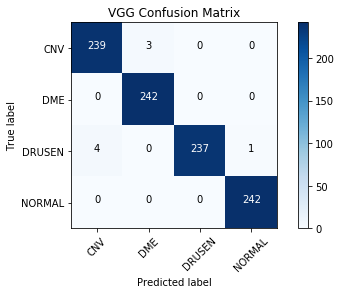

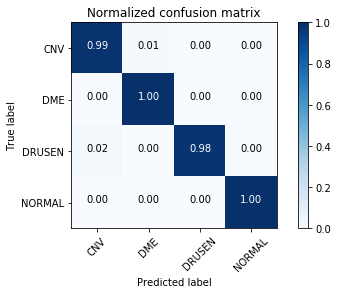

In [26]:
class_names = list(test_generator.class_indices.keys())
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_real)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='VGG Confusion Matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### ROC curve

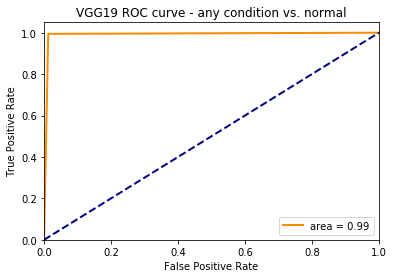

In [25]:
# Recreate labels - 1 if not normal, 0 if normal
y_test_roc = [bool(y) for y in y_test]
y_pred_roc = [bool(y) for y in y_pred_real]

fpr, tpr, _ = roc_curve(y_test_roc, y_pred_roc)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='area = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG19 ROC curve - any condition vs. normal')
plt.legend(loc="lower right")
plt.show()

#### Load IV3

In [36]:
# Load the VGG model
iv3 = load_model('InceptionV3.h5', custom_objects={'tf':tf})
print('Done.')

Done.


#### Test IV3

In [37]:
# Constants
img_width, img_height = 256, 256
train_data_dir = "data/train"
validation_data_dir = "data/val"
test_data_dir = "data/test"

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  horizontal_flip = True,
                                  fill_mode = "nearest",
                                  zoom_range = 0.3,
                                  width_shift_range = 0.3,
                                  height_shift_range=0.3,
                                  rotation_range=30)
# Test the network!! First initiate test generator
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                        target_size = (img_height, img_width),
                                                        class_mode = "categorical",
                                                        shuffle = False)
# Now test model
y_pred = iv3.predict_generator(test_generator)
print('Done.')

Found 968 images belonging to 4 classes.
Done.


In [38]:
y_pred_real = np.argmax(y_pred,axis=1)
y_test = test_generator.classes

#### Confusion matrix

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[206   6  25   5]
 [ 74  85  47  36]
 [ 61  12 144  25]
 [ 13   5  14 210]]
Normalized confusion matrix
[[0.85 0.02 0.1  0.02]
 [0.31 0.35 0.19 0.15]
 [0.25 0.05 0.6  0.1 ]
 [0.05 0.02 0.06 0.87]]


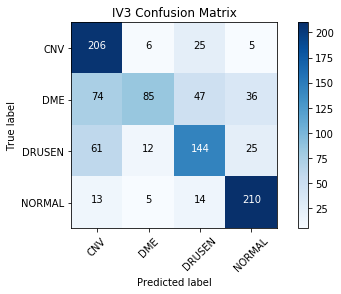

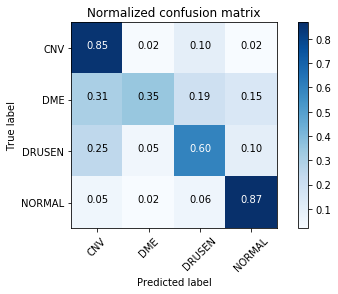

In [40]:
class_names = list(test_generator.class_indices.keys())
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_real)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='IV3 Confusion Matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### ROC curve

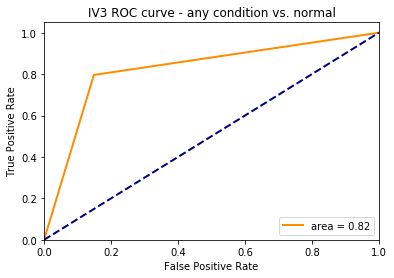

In [41]:
# Recreate labels - 1 if not normal, 0 if normal
y_test_roc = [bool(y) for y in y_test]
y_pred_roc = [bool(y) for y in y_pred_real]

fpr, tpr, _ = roc_curve(y_test_roc, y_pred_roc)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='area = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('IV3 ROC curve - any condition vs. normal')
plt.legend(loc="lower right")
plt.show()